#  Аналих тарифных планов для телеком компании

Клиентам федерального оператора сотовой связи предлагают два ключевых тарифных плана: «Смарт» и «Ультра». Для анализа тарифов предоставленны данные о 500 пользователях за 2018 год: город, каким тарифом пользуются, сколько звонков и сообщений каждый отправил, как расходовался интернет-трафик.  
  
Задача: проанализировать поведение клиентов, выявить эффективный тариф и дать рекомендации для коммерческого отдела по корректировкам рекламного бюджета.

1. [Получение данных.](#step1)  
2. [Предобработка данных.](#step2)  
3. [Добавление новых параметров.](#step3) 
4. [Анализ данных.](#step4) 
5. [Статистическая проверка гипотез.](#step5) 
6. [Общий вывод.](#step6) 

## Получение данных. <a id="step1"></a>    

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats as st

Прочитаем файлы и сохраним в переменных, получим первые строки таблиц и информацию о данных.

In [2]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Таблица users (информация о пользователях)**:
* user_id — уникальный идентификатор пользователя;
* first_name — имя пользователя;
* last_name — фамилия пользователя;
* age — возраст пользователя (годы);
* reg_date — дата подключения тарифа (день, месяц, год);
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
* city — город проживания пользователя;
* tariff — название тарифного плана.

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Таблица calls (информация о звонках)**:
* id — уникальный номер звонка;
* call_date — дата звонка;
* duration — длительность звонка в минутах;
* user_id — идентификатор пользователя, сделавшего звонок.

In [5]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Таблица messages (информация о сообщениях)**:
* id — уникальный номер сообщения;
* message_date — дата сообщения;
* user_id — идентификатор пользователя, отправившего сообщение.

In [7]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


**Таблица internet (информация об интернет-сессиях)**:
* id — уникальный номер сессии;
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
* session_date — дата интернет-сессии;
* user_id — идентификатор пользователя.

In [9]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Таблица tariffs (информация о тарифах)**:
* tariff_name — название тарифа;
* rub_monthly_fee — ежемесячная абонентская плата в рублях;
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
* messages_included — количество сообщений в месяц, включённых в абонентскую плату;
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

In [11]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Выводы

Каждая строка таблицы *users* содержит информацию об отдельном пользоватле из выборки. Каждая строка таблицы *calls* содержит информацию об отдельном звонке, совершенным пользователем. Каждая строка таблицы *messages* содержит информацию об отдельном сообщении, отправленным пользователем. Каждая строка таблицы *internet* содержит информацию об уникальной интернет-сессии, совершенной пользователем. Таблица *tariffs* содержит информацию о условиях тарифов "Ультра" и "Смарт". Проблемы, которые нужно решать - пропуски в столбце *churn_date* таблицы *users*; строковый тип данных в столбцах *churn_date*, *reg_date* таблицы *users*; *call_date* в таблице *calls*; *message_date* в таблице *messages*; *session_date* в таблице *internet*.

## Предобработка данных. <a id="step2"></a> 

### Обработка пропусков

Пропущеные значения в столбце *churn_date* таблицы *users* говорят о том, что тариф ещё действовал на момент выгрузки данных. Оставим эти значения без изменений, так как информация из этого столбца не понадобиться. 

### Замена типа данных

Приведем значения в столбцах с датами к типу datetime.

In [12]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'],format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'],format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'],format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'],format='%Y-%m-%d')

### Округление значений

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Округлим значения по правилам оператора.

In [13]:
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Длительность многих звонков — 0.0 минут. Это могут быть звонки, когда пользователь не дозвонился до адресата. Оставим эти значения без изменения, так как по нулевому значению мы можем посчитать и количество совершенных звонков в месяц, и общее количество потраченных пользователем минут не изменится.

In [14]:
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000
3,3,1000_3,551.0,2018-08-22,1000
4,4,1000_4,303.0,2018-09-24,1000


### Выводы

На этапе предобработки данных обнаружились пропуски, которые было решено оставить без изменения, так как подходящего значения на замену не нашлось и с нашим исследованием эти пустые значения не коррелируют. Были изменены в большую сторону значения длительности звонков и объем использованного интернет-трафика по правилам оператора. Длительность звонков 0.00 минут осталась без изменения, так как обработка этих значений может повлиять на результаты исследования. 

## Добавление новых параметров. <a id="step3"></a> 

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.

In [15]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month

In [16]:
calls_month = df_calls.groupby(['user_id','month'])['duration'].agg(['count', 'sum']).reset_index()
calls_month.columns = ['user_id','month','calls', 'minutes_used']
calls_month.head()

,user_id,month,calls,minutes_used
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


Посчитаем для каждого пользователя количество отправленных сообщений по месяцам.

In [17]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [18]:
messages_month = df_messages.groupby(['user_id', 'month'])['message_date'].count().reset_index()
messages_month.columns = ['user_id','month','messages_used']
messages_month.head()

,user_id,month,messages_used
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам.

In [19]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

In [20]:
internet_month = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_month.head()

,user_id,month,mb_used
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


Объеденим таблицы.

In [21]:
df_1 = calls_month.merge(messages_month, on=('user_id', 'month'), how='outer')
df_2 = df_1.merge(internet_month, on=('user_id', 'month'), how='outer')
df_3 = df_users.merge(df_2, on='user_id',how='outer')

In [22]:
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})
df_final = df_3.merge(df_tariffs, on='tariff',how='outer')
df_final.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls,minutes_used,messages_used,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,2256.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23257.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14016.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,14070.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,14581.0,1000,30720,3000,1950,150,1,1


Проверим наличие дубликатов в таблице методом .duplicated(). В сочетании с методом sum() он возвращает количество дубликатов. Если найдутся, удалим, и проверим, все ли удалились.

In [23]:
print(df_final.duplicated().sum()) 

0


Дубликатов нет.

Посчитаем для каждого пользователя помесячную выручку с каждого пользователя.

In [24]:
def minutes_money_counter(data):
    if data['minutes_used'] > data['minutes_included']:
        return (data['minutes_used'] - data['minutes_included']) * data['rub_per_minute']
    else:
        return 0

In [25]:
df_final['money_for_minutes'] = df_final.apply(minutes_money_counter, axis=1)

In [26]:
def messages_money_counter(data):
    if data['messages_used'] > data['messages_included']:
        return (data['messages_used'] - data['messages_included']) * data['rub_per_message']
    else:
        return 0

In [27]:
df_final['money_for_messages'] = df_final.apply(messages_money_counter, axis=1)

In [28]:
def mb_money_counter(data):
    if data['mb_used'] > data['mb_per_month_included']:
        return np.ceil((data['mb_used'] - data['mb_per_month_included'])/1000) * data['rub_per_gb']
    else:
        return 0

In [29]:
df_final['money_for_mb'] = df_final.apply(mb_money_counter, axis=1)

In [30]:
df_final['proceeds'] = df_final['money_for_minutes'] + df_final['money_for_messages'] + df_final['money_for_mb']\
+ df_final['rub_monthly_fee']

In [31]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [32]:
df_final.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls,minutes_used,messages_used,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,money_for_minutes,money_for_messages,money_for_mb,proceeds
318,1180,27,NaN,Москва,Лев,Мишин,2018-02-02,ultra,12.0,20.0,134.0,23.0,26747.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2949,1438,24,2018-12-24,Екатеринбург,Нателла,Бородина,2018-10-05,smart,11.0,44.0,307.0,66.0,11880.0,50,15360,500,550,200,3,3,0.0,48.0,0.0,598.0
1232,1054,33,NaN,Омск,Кристина,Платонова,2018-03-20,smart,4.0,81.0,564.0,54.0,16999.0,50,15360,500,550,200,3,3,192.0,12.0,400.0,1154.0
2188,1262,21,NaN,Ульяновск,Антонина,Ларина,2018-03-17,smart,12.0,66.0,472.0,40.0,18871.0,50,15360,500,550,200,3,3,0.0,0.0,800.0,1350.0
148,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra,10.0,75.0,510.0,14.0,13865.0,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


### Выводы

Мы добавили в таблицу новые параметры для оценки тарифов. 

## Анализ данных. <a id="step4"></a> 

Опишем поведение клиентов оператора, исходя из выборки. Определим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. 

Построим сводные таблицы для тарифов "Смарт" и "Ультра".

In [33]:
smart = df_final.query('tariff in "smart"')
ultra = df_final.query('tariff in "ultra"')

In [34]:
smart_pivot = smart.pivot_table(index='month', values=['minutes_used', 'messages_used', 'mb_used'], aggfunc='mean').reset_index()
ultra_pivot = ultra.pivot_table(index='month', values=['minutes_used', 'messages_used', 'mb_used'], aggfunc='mean').reset_index()

In [35]:
smart_pivot.head(12)

,month,mb_used,messages_used,minutes_used
0,1.0,8524.441176,20.000000,203.852941
1,2.0,11611.396552,27.940000,298.689655
2,3.0,15123.857143,35.550725,390.051948
3,4.0,13479.482143,35.864583,367.133929
4,5.0,15825.198582,39.032787,387.361702
5,6.0,15814.768293,38.577465,398.067485
6,7.0,15763.512438,38.988506,408.353234
7,8.0,16703.252137,38.750000,423.269231
8,9.0,16324.526923,39.219731,430.266409
9,10.0,16778.564626,39.082677,427.590444


In [36]:
ultra_pivot.head(12)

,month,mb_used,messages_used,minutes_used
0,1.0,13153.555556,43.428571,428.111111
1,2.0,12858.500000,32.937500,297.125000
2,3.0,17551.972973,47.800000,489.648649
3,4.0,16843.800000,44.512821,475.301887
4,5.0,19674.848485,48.769231,534.250000
5,6.0,19170.457831,52.313433,497.469136
6,7.0,20742.588889,62.136986,564.397727
7,8.0,19778.915094,58.897727,530.611650
8,9.0,19390.824561,63.294737,558.882883
9,10.0,20228.327869,69.776699,581.728814


Посчитаем среднее количество, дисперсию и стандартное отклонение. 

In [37]:
def descriptive_stat(data):
    columns = ['mb_used', 'messages_used', 'minutes_used']
    for column in columns:
        print(column)
        print('Среднее:', data[column].mean())
        print('Дисперсия:', np.var(data[column], ddof=1))
        print('Стандартное отклонение:', np.sqrt(np.var(data[column])))

In [38]:
descriptive_stat(smart)

mb_used
Среднее: 16236.47262118492
Дисперсия: 34443100.68133359
Стандартное отклонение: 5867.507262880088
messages_used
Среднее: 38.71644120707596
Дисперсия: 717.5942011753547
Стандартное отклонение: 26.780979129042816
minutes_used
Среднее: 419.0629779577148
Дисперсия: 35844.1895513438
Стандартное отклонение: 189.2830296395594


**Тариф "Смарт"**: среднее арифметическое значение использованного пользователями интернет-трафика - 16236 (выходит за объем, включенный в абанентскую плату), стандартное отклонение - 5867, на столько значения в выборке разбросаны вокруг среднего на числовой оси; среднее количество использованных сообщений за 12 месяцев - 39 (входит в объем, включенный в абанентскую плату), значения в выборке отличаются от среднего на 27; среднее арифметическое использованных минут - 419 (входит в объем, включенный в абанентскую плату), значения в выборке отличаются от среднего на 118. Среднее арифметическое использованных минут и сообщений входит в объем, включенный в абанентскую плату, но есть пользователи в выборке, которые используют большее количество сообщений и минут, чем включено в тариф.

In [39]:
descriptive_stat(ultra)

mb_used
Среднее: 19686.76717948718
Дисперсия: 99043439.60795662
Стандартное отклонение: 9946.952125800852
messages_used
Среднее: 61.161006289308176
Дисперсия: 2109.6591828651995
Стандартное отклонение: 45.90212983637779
minutes_used
Среднее: 545.4511041009464
Дисперсия: 94203.4183961481
Стандартное отклонение: 306.76434143143143


**Тариф "Ультра"**: среднее арифметическое значение использованного пользователями интернет-трафика - 19687 (входит в объем, включенный в абанентскую плату), стандартное отклонение - 9946, разброс значений в выборке больше, чем в тарифе "Смарт"; среднее количество использованных сообщений за 12 месяцев - 61 (входит в объем, включенный в абанентскую плату), стандартное отклонение - 46, разброс значений в выборке больше, чем в тарифе "Смарт"; среднее арифметическое использованных минут - 545 (входит в объем, включенный в абанентскую плату), значения в выборке отличаются от среднего на 306 минут, разброс значений в выборке больше, чем в тарифе "Смарт". Пользователи тарифа "Ультра" не выходят за объем, включенный в абанентскую плату.

Построим графики для наглядного отображения поведения клиентов.

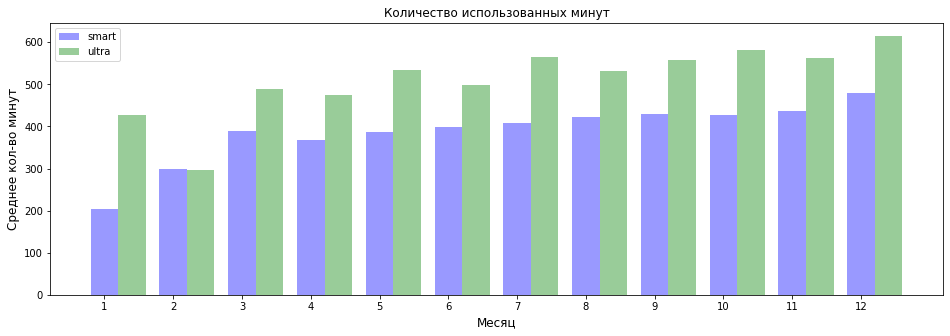

In [51]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

ax1.set_ylabel('Среднее кол-во минут', fontsize=12)
ax1.set_xlabel('Месяц', fontsize=12)
ax1.set_title('Количество использованных минут')

months_index = np.arange(smart_pivot['month'].min(), smart_pivot['month'].max()+1)
width = 0.4
plt.bar(smart_pivot['month'], smart_pivot['minutes_used'], width, alpha=0.4, color = "b", label="smart")
plt.bar(ultra_pivot['month']+ width, ultra_pivot['minutes_used'], width, alpha=0.4, color = "g", label="ultra")
plt.xticks(months_index)
plt.legend()
plt.show()

Пользователи с тарифом "Ультра" в среднем используют большее количество минут, чем пользователи тарифа "Смарт".

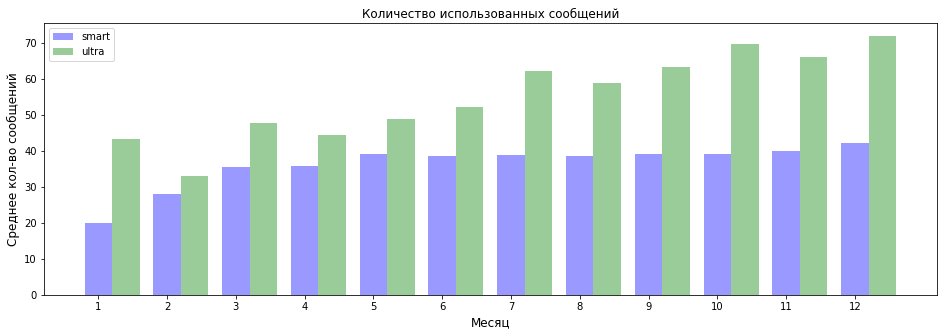

In [52]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

ax1.set_ylabel('Среднее кол-во сообщений', fontsize=12)
ax1.set_xlabel('Месяц', fontsize=12)
ax1.set_title('Количество использованных сообщений')

months_index = np.arange(smart_pivot['month'].min(), smart_pivot['month'].max()+1)
width = 0.4
plt.bar(smart_pivot['month'], smart_pivot['messages_used'], width, alpha=0.4, color = "b", label="smart")
plt.bar(ultra_pivot['month']+ width, ultra_pivot['messages_used'], width, alpha=0.4, color = "g", label="ultra")
plt.xticks(months_index)
plt.legend()
plt.show()

Пользователи с тарифом "Ультра" в среднем посылают большее количество сообщений, чем пользователи тарифа "Смарт".

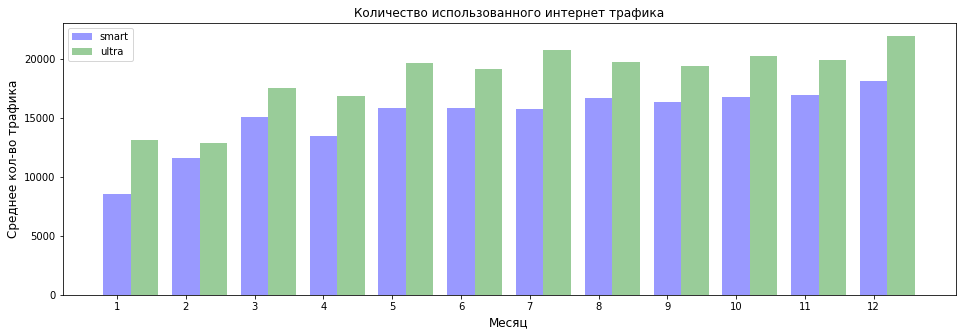

In [53]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

ax1.set_ylabel('Среднее кол-во трафика', fontsize=12)
ax1.set_xlabel('Месяц', fontsize=12)
ax1.set_title('Количество использованного интернет трафика')

months_index = np.arange(smart_pivot['month'].min(), smart_pivot['month'].max()+1)
width = 0.4
plt.bar(smart_pivot['month'], smart_pivot['mb_used'], width, alpha=0.4, color = "b", label="smart")
plt.bar(ultra_pivot['month']+ width, ultra_pivot['mb_used'], width, alpha=0.4, color = "g", label="ultra")
plt.xticks(months_index)
plt.legend()
plt.show()

Пользователи с тарифом "Ультра" в среднем используют большее количество интернет-трафика, чем пользователи тарифа "Смарт".

### Выводы

Пользователи с тарифом "Ультра" использую больше минут, сообщений, интернет-трафика, чем пользователи тарифа "Смарт". Разброс значений использованного интернет-трафика, сообщений, минут в тарифе "Ультра" больше, чем в тарифе "Смарт". Отдельные пользователи тарифа "Смарт" используют большее количество интернет-трафика, сообщений, минут, чем включено в абанентскую плату. Пользователи тарифа "Ультра" не выходят за объем, включенный в абанентскую плату.

## Статистическая проверка гипотез. <a id="step5"></a> 

**Проверим гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**

Сформулируем нулевую гипотезу H₀: средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт". Сформулируем альтернативную гипотезу H₁: средняя выручка тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт".

Найдем среднюю вырочку в тарифах.

In [43]:
mean_proceeds_smart = smart['proceeds'].mean()
print(mean_proceeds_smart)

1305.0677130044844


In [44]:
mean_proceeds_ultra = ultra['proceeds'].mean()
print(mean_proceeds_ultra)

2072.920892494929


In [54]:
alpha = 0.05

results = st.ttest_ind(
    smart['proceeds'], 
    ultra['proceeds'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 

p-значение: 4.574625830653468e-151
Отвергаем нулевую гипотезу.


**Проверим гипотезу:средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**.

Сформулируем нулевую гипотезу H₀: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Сформулируем альтернативную гипотезу H₁: средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

Найдем среднюю выручку пользователей в Москве и регионах.

In [46]:
proceeds_moscow = df_final.query('city == "Москва"')
proceeds_country = df_final.query('city != "Москва"')

In [47]:
mean_proceeds_moscow = proceeds_moscow['proceeds'].mean()
print(mean_proceeds_moscow)

1556.7790507364975


In [48]:
mean_proceeds_country = proceeds_country['proceeds'].mean()
print(mean_proceeds_country)

1536.6637236084453


In [55]:
alpha = 0.05

results = st.ttest_ind(
    proceeds_moscow['proceeds'], 
    proceeds_country['proceeds'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 

p-значение: 0.5797569997439935
Не получилось отвергнуть нулевую гипотезу.


### Выводы

Данные противоречат гипотезе "Средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"", мы отвергаем эту гипотезу. Данные не противоречат гипотезе "Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов", мы не отвергаем эту гипотезу. Средняя выручка тарифа "Ультра" - 2073, средняя выручка тарифа "Смарт" - 1305. 

## Общий вывод. <a id="step6"></a>

Мы проанализировали услуги федерального оператора сотовой связи на выборке из 500 пользователей двух основных тарифов компании — "Смарт" и "Ультра". Предоставленные данные содержали информацию о продолжительности и количестве сделанных звонков, отправленных сообщений и использованного интернет-трафика, а также подробную информацию о пользователях и условиях тарифных планов.  
  
В результате проверки гипотез было выявлено, что с высокой статистической значимостью можно принять утверждение, что тарифный план "Ультра" выгоднее для компании с финансовой точки зрения. Поэтому **рекомендуем пересмотреть распределение рекламного бюджета в пользу тарифа "Ультра".   
  
Также стоить отметить, что **"поведение" клиентов обоих тарифов схоже** и основная аудитория распределена относительно равномерно в диапазоне 220-700 минут разговора, 0-50 смс-сообщений и 11-25 Гб интернет-трафика. Можно в дальнейшем углубить исследование поведения клиентов, основываясь на гипотезе, что их основные потребности в объеме услуг одинаковы.  
  
**Рекомендуем рассмотреть стимулирующие акции в поддержку перехода лояльных клиентов из тарифа "Смарт" в тариф "Ультра"**, при этом первоначально рекомендуем протестировать гипотезы, связанные с акциями на интернет-трафик, так как по предварительным исследованиям по этой статье чаще всего клиенты платят за услуги сверх лимита.